#### Mini projekt - modele generatywne
Due May 13, 2024 4:00 PM

Tym razem zadanie będzie polegało na stworzeniu modelu generatywnego który generował będzie nowe obrazki przedstawiające znaki drogowe. Do wyboru mają Państwo dowolny model generatywny (VAE, GAN, GLOW, VAEGAN, czy modele dyfuzyjne. W przypadku tych ostatnich polecam zapoznanie się z takim notebookiem: https://huggingface.co/learn/diffusion-course/en/unit1/3, jeżeli będą Państwo chętni to możemy wspólnie przejść przez niego w ramach laborek konsultacyjnych.

Zbiór danych udostępniłem Państwu przez onedrive (trafic_32.zip) i ma taką samą strukturę jak poprzednio (zgodną z domyślnymi ustawieniami ImageFolderu). Znaki podzielone są na klasy, które jak najbardziej mogą Państwo wykorzystywać do generowania próbek. Tym razem zamiast predykcji proszę o zwrócenie mi kodu z implementacją eksperymentów i przykładowe 1000 próbek wygenerowanych za pomocą Państwa metody.
Bardzo proszę żeby jak zwykle zwracali mi Państwo archiwum zip, jak zwykle proszę też o zastosowanie się do instrukcji:
- Archiwum powinno być nazwane jak ostatnio poniedzialek/piatek_nazwisko1_nazwisko2.zip (lub nazwa drużyny)
- W archiwum proszę bez zbędnych podfolderów umieścić pliki ze swoim kodem i wygenerowane obrazki nazwane odpowiednio poniedzialek_nazwisko1_nazwisko2.pt (lub nazwa drużyny)
- Wygenerowane obrazki, proszę zapisywać po prostu w formie torchowego tensora (na cpu, po detach, czyli np. wykonując komendę torch.save(generated_imgs.cpu().detach(),"poniedzialek_nazwisko1_nazwisko2.pt") ). Tensor zgodnie z konwencją powinien mieć wymiary [1000, 3, 32, 32]

Ewaluacja:
- Wygenerowane obrazki porównywał będę do zbioru testowego za pomocą metryki Frechet Inception Distance o której wspominałem na ćwiczeniach. Jeżeli chcieliby Państwo z niej skorzystać do ewaluacji swoich modeli, to odsyłam do repozytorium z wygodną implementacją: https://github.com/mseitzer/pytorch-fid
- W zbiorze testowym obrazki mają ten sam rozkład klas co w treningowym
- Proszę pamiętać o denormalizacji próbek :)

In [32]:
# import zipfile

# # Specify the path to the zip file
# zip_file_path = '/content/trafic_32.zip'

# # Specify the directory to extract the contents to
# extract_dir = '/content/data/'

# # Extract the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# # Check the extracted directory structure
# !ls {extract_dir}


In [33]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [34]:
DATA_PATH = './data'
BATCH_SIZE = 32
NUM_WORKERS = 4

LATENT_DIMENSIONS = 100
EPOCHS = 15

LEARNING_RATE = 0.00015
BETA1 = 0.5
BETA2 = 0.999
GAMMA = 0.99

In [35]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:2


In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = ImageFolder(root=DATA_PATH, transform=transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
# train_set, val_set = torch.utils.data.random_split(dataset, [45000, 5000])

print(dataset.classes)
print(len(dataset.classes))
print(len(dataset))


['trafic_32']
1
39209


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


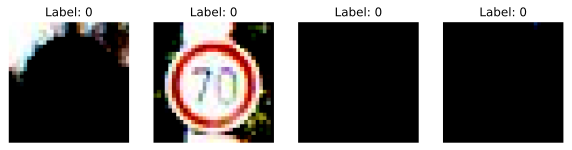

In [49]:
def denormalize(images):
    mean = 0.5
    std = 0.5
    return images * std + mean

def show_images(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for ax, image, label in zip(axes, images, labels):
        # Denormalize the image
        denorm_image = denormalize(image)

        ax.imshow(denorm_image.permute(1, 2, 0))
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

# Get 4 random images from the dataset
data_iter = iter(data_loader)
images, labels = next(data_iter)


# Display the images
show_images(images[0:4], labels[0:4])

### GAN

In [28]:
class Discriminator(nn.Module):
    def __init__(self, input_dimension, hidden_dimension):
        super(Discriminator, self).__init__()

        self.convolution1 = nn.Conv2d(input_dimension, hidden_dimension, kernel_size=4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(hidden_dimension)
        self.convolution2 = nn.Conv2d(hidden_dimension, hidden_dimension*2, kernel_size=4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(hidden_dimension*2)
        self.convolution3 = nn.Conv2d(hidden_dimension*2, hidden_dimension*4, kernel_size=4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(hidden_dimension*4)
        self.convolution4 = nn.Conv2d(hidden_dimension*4, 1, kernel_size=4, stride=1, padding=0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.convolution1(x)))
        x = self.relu(self.batch_norm2(self.convolution2(x)))
        x = self.relu(self.batch_norm3(self.convolution3(x)))
        x = self.sigmoid(self.convolution4(x))
        return x

class Generator(nn.Module):
    def __init__(self, latent_dimension, hidden_dimension, output_dimension):
        super(Generator, self).__init__()
        self.convtrans1 = nn.ConvTranspose2d(latent_dimension, hidden_dimension*4, kernel_size=4, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(hidden_dimension*4)
        self.convtrans2 = nn.ConvTranspose2d(hidden_dimension*4, hidden_dimension*2, kernel_size=4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(hidden_dimension*2)
        self.convtrans3 = nn.ConvTranspose2d(hidden_dimension*2, hidden_dimension, kernel_size=4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(hidden_dimension)
        self.convtrans4 = nn.ConvTranspose2d(hidden_dimension, output_dimension, 4, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.convtrans1(x)))
        x = self.relu(self.batch_norm2(self.convtrans2(x)))
        x = self.relu(self.batch_norm3(self.convtrans3(x)))
        x = self.tanh(self.convtrans4(x))
        return x

In [29]:
generator = Generator(LATENT_DIMENSIONS, 64, 3).to(device)
discriminator = Discriminator(3, 64).to(device)

optimizer_generator = optim.Adam(generator.parameters(), lr=0.00015, betas=(BETA1, BETA2))
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=0.00015, betas=(BETA1, BETA2))

scheduler_generator = optim.lr_scheduler.ExponentialLR(optimizer_generator, GAMMA)
scheduler_discriminator = optim.lr_scheduler.ExponentialLR(optimizer_discriminator, GAMMA)

criterion = nn.BCELoss()

noise = torch.randn(16, LATENT_DIMENSIONS, 1, 1, device=device)

In [30]:
G_losses = []
D_losses = []
for epoch in range(EPOCHS):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(data_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        optimizer_discriminator.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.ones((b_size,), dtype=torch.float, device=device) # Setting labels for real images
        # Forward pass real batch through D
        output = discriminator(real_images).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, LATENT_DIMENSIONS,device=device)
        # Generate fake image batch with Generator
        fake_images = generator(noise)
        label_fake = torch.zeros((b_size,), dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = discriminator(fake_images.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        error_discriminator.backward()
        # Update D
        optimizer_discriminator.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizer_generator.zero_grad()
        label = torch.ones((b_size,), dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake_images).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizer_generator.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())

    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    scheduler_generator.step()
    scheduler_discriminator.step()
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = generator(noise).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv_transpose2d, but got input of size: [32, 100]